# 2025 CITS4012 Project
*Group No 26*

# Readme
*If there is something to be noted for the marker, please mention here.*

*If you are planning to implement a program with Object Oriented Programming style, please put those the bottom of this ipynb file*

# 1.Dataset Processing
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

In [42]:
#  paths, installs, imports
!pip -q install nltk

import os, re, json, pickle
from pathlib import Path
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import math
import time
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

In [43]:
USE_DRIVE = True                  # set to False if you want to upload files manually
DATA_DIR = "/content/drive/MyDrive/CITS4012_Group_26"

if USE_DRIVE:
    from google.colab import drive
    drive.mount('/content/drive')
    DATA_DIR = Path(DATA_DIR)
    assert DATA_DIR.exists(), f"DATA_DIR not found: {DATA_DIR}"
else:
    from google.colab import files
    print("Please upload train.json, test.json, validation.json ...")
    _ = files.upload()  # choose the three JSON files
    DATA_DIR = Path("/content")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
#  Load data
train_path = DATA_DIR / "train.json"
test_path  = DATA_DIR / "test.json"
val_path   = DATA_DIR / "validation.json"

for p in [train_path, test_path, val_path]:
    if not p.exists():
        raise FileNotFoundError(f"Missing file: {p}")

train = pd.read_json(train_path)
test  = pd.read_json(test_path)
validation = pd.read_json(val_path)

print("Loaded:", len(train), len(validation), len(test))
print(train.head(3))

Loaded: 23088 1304 2126
                                             premise  \
0  Pluto rotates once on its axis every 6.39 Eart...   
1  ---Glenn =====================================...   
2  geysers - periodic gush of hot water at the su...   

                                          hypothesis    label  
0   Earth rotates on its axis once times in one day.  neutral  
1   Earth rotates on its axis once times in one day.  entails  
2  The surface of the sun is much hotter than alm...  neutral  


In [45]:
#  Cleaning
# Keep common science symbols, but we'll also handle dots that are NOT inside numbers.
_ALLOWED = r"[^a-z0-9\.\-\+%°/<>=,\s]"  # keep common science symbols

def clean_text(text: str) -> str:
    text = str(text).lower()

    # replace dots not between digits with space (keeps 3.14 etc.)
    text = re.sub(r'(?<!\d)\.(?!\d)', ' ', text)

    # drop disallowed chars to space
    text = re.sub(_ALLOWED, ' ', text)
    # keep only a-z, 0-9, dots, and whitespace (extra safety)
    text = re.sub(r'[^a-z0-9.\s]', ' ', text)
    # normalize spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

for df in (train, test, validation):
    df["premise_clean"] = df["premise"].apply(clean_text)
    df["hypothesis_clean"] = df["hypothesis"].apply(clean_text)

print("Cleaned example:\n", train[["premise_clean","hypothesis_clean","label"]].head(1))

Cleaned example:
                                        premise_clean  \
0  pluto rotates once on its axis every 6.39 eart...   

                                  hypothesis_clean    label  
0  earth rotates on its axis once times in one day  neutral  


In [46]:
# Tokenisation (NLTK)
import nltk
# Old vs new tokeniser packages; try both to be safe in Colab
try:
    nltk.download('punkt', quiet=True)
except Exception as e:
    print("punkt download issue:", e)
try:
    nltk.download('punkt_tab', quiet=True)
except Exception:
    pass

from nltk.tokenize import word_tokenize

In [47]:
# Contractions (all lowercase to match our lowercasing)
contraction_dict = {
    "ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because",
    "could've": "could have", "couldn't": "could not", "didn't": "did not",
    "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not",
    "haven't": "have not", "he'd": "he would", "he'll": "he will", "he's": "he is",
    "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
    "i'd": "i would", "i'd've": "i would have", "i'll": "i will", "i'll've": "i will have",
    "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
    "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have", "it's": "it is",
    "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have",
    "mightn't": "might not", "mightn't've": "might not have", "must've": "must have",
    "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not",
    "needn't've": "need not have", "o'clock": "of the clock", "oughtn't": "ought not",
    "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not",
    "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have",
    "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have",
    "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
    "so's": "so as", "this's": "this is", "that'd": "that would", "that'd've": "that would have",
    "that's": "that is", "there'd": "there would", "there'd've": "there would have",
    "there's": "there is", "here's": "here is", "they'd": "they would", "they'd've": "they would have",
    "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have",
    "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have",
    "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have",
    "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
    "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have",
    "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will",
    "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is",
    "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
    "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have",
    "y'all": "you all", "y'all'd": "you all would", "y'all'd've": "you all would have",
    "y'all're": "you all are", "y'all've": "you all have", "you'd": "you would",
    "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
    "you're": "you are", "you've": "you have"
}

# Faster contraction replacement with regex
_contr_pat = re.compile(r'\b(' + '|'.join(map(re.escape, contraction_dict.keys())) + r')\b')

def _expand_contractions(s: str) -> str:
    return _contr_pat.sub(lambda m: contraction_dict[m.group(0)], s)

def pre_process(sent_list):
    """
    Preprocess a list of sentences:
      - Expand contractions
      - Remove punctuation (after expansion)
      - Tokenize with NLTK
    """
    out = []
    for sent in sent_list:
        s = str(sent).lower()
        s = _expand_contractions(s)
        s = re.sub(r'[^\w\s]', '', s)  # remove punctuation
        out.append(word_tokenize(s))
    return out

print("Tokenizing premises...")
train_premise_tokens = pre_process(train["premise_clean"].tolist())
test_premise_tokens  = pre_process(test["premise_clean"].tolist())
val_premise_tokens   = pre_process(validation["premise_clean"].tolist())

print("Tokenizing hypotheses...")
train_hypothesis_tokens = pre_process(train["hypothesis_clean"].tolist())
test_hypothesis_tokens  = pre_process(test["hypothesis_clean"].tolist())
val_hypothesis_tokens   = pre_process(validation["hypothesis_clean"].tolist())

print("Example tokenized premise:", train_premise_tokens[0][:20])
print("Example tokenized hypothesis:", train_hypothesis_tokens[0][:20])

Tokenizing premises...
Tokenizing hypotheses...
Example tokenized premise: ['pluto', 'rotates', 'once', 'on', 'its', 'axis', 'every', '639', 'earth', 'days']
Example tokenized hypothesis: ['earth', 'rotates', 'on', 'its', 'axis', 'once', 'times', 'in', 'one', 'day']


In [48]:
#clip very long sequences (recommended)
CLIP_LENGTHS = True
PREMISE_MAX_LEN_CAP = 512    # adjust if you want
HYP_MAX_LEN_CAP = 128             # adjust if you want

# Build vocab (train only)
PAD_TOKEN = "<pad>"
UNK_TOKEN = "<unk>"
word_to_ix = {PAD_TOKEN: 0, UNK_TOKEN: 1}

for sent in (train_premise_tokens + train_hypothesis_tokens):
    for w in sent:
        if w not in word_to_ix:
            word_to_ix[w] = len(word_to_ix)

PAD_ID = word_to_ix[PAD_TOKEN]   # 0
UNK_ID = word_to_ix[UNK_TOKEN]   # 1

def to_index(token_lists, to_ix):
    unk = to_ix[UNK_TOKEN]
    return [[to_ix.get(w, unk) for w in sent] for sent in token_lists]

vocab_size = len(word_to_ix)
print("Vocab size:", vocab_size)

# Now convert all tokens → indices
train_premise_idx = to_index(train_premise_tokens, word_to_ix)
train_hypothesis_idx = to_index(train_hypothesis_tokens, word_to_ix)
test_premise_idx = to_index(test_premise_tokens, word_to_ix)
test_hypothesis_idx = to_index(test_hypothesis_tokens, word_to_ix)
val_premise_idx = to_index(val_premise_tokens, word_to_ix)
val_hypothesis_idx = to_index(val_hypothesis_tokens, word_to_ix)


def _clip_lists(seqs, cap):
    return [seq[:cap] if len(seq) > cap else seq for seq in seqs]

if CLIP_LENGTHS:
    train_premise_idx    = _clip_lists(train_premise_idx, PREMISE_MAX_LEN_CAP)
    test_premise_idx     = _clip_lists(test_premise_idx, PREMISE_MAX_LEN_CAP)
    val_premise_idx      = _clip_lists(val_premise_idx, PREMISE_MAX_LEN_CAP)
    train_hypothesis_idx = _clip_lists(train_hypothesis_idx, HYP_MAX_LEN_CAP)
    test_hypothesis_idx  = _clip_lists(test_hypothesis_idx, HYP_MAX_LEN_CAP)
    val_hypothesis_idx   = _clip_lists(val_hypothesis_idx, HYP_MAX_LEN_CAP)

# ==== Sequence length stats ===================================================
MAX_LENGTH_PREMISE   = max(len(s) for s in train_premise_idx) if train_premise_idx else 0
MAX_LENGTH_HYPOTHESIS = max(len(s) for s in train_hypothesis_idx) if train_hypothesis_idx else 0

print(f"Max premise length (train): {MAX_LENGTH_PREMISE}")
print(f"Max hypothesis length (train): {MAX_LENGTH_HYPOTHESIS}")

Vocab size: 20499
Max premise length (train): 512
Max hypothesis length (train): 36


In [49]:
# Labels
label_to_ix = {"entails": 0, "neutral": 1}
ix_to_label = {v:k for k,v in label_to_ix.items()}

train_labels = [label_to_ix[l] for l in train["label"]]
test_labels  = [label_to_ix[l] for l in test["label"]]
val_labels   = [label_to_ix[l] for l in validation["label"]]

In [50]:
# Final stats
print(f"Training examples:   {len(train_premise_idx)}")
print(f"Validation examples: {len(val_premise_idx)}")
print(f"Test examples:       {len(test_premise_idx)}")
print(f"Vocabulary size:     {vocab_size}")
print(f"Num labels:          {len(label_to_ix)}")

Training examples:   23088
Validation examples: 1304
Test examples:       2126
Vocabulary size:     20499
Num labels:          2


In [51]:
# Sanity printout
print("Variables are ready for model training!")
print(f"Vocab size:           {vocab_size}")
print(f"Max Premise Length:   {MAX_LENGTH_PREMISE}")
print(f"Max Hypothesis Length:{MAX_LENGTH_HYPOTHESIS}")
print(f"Label mapping:        {label_to_ix}")
print(f"Example premise idx:  {train_premise_idx[0][:15]}")


Variables are ready for model training!
Vocab size:           20499
Max Premise Length:   512
Max Hypothesis Length:36
Label mapping:        {'entails': 0, 'neutral': 1}
Example premise idx:  [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


In [52]:
# check sequence length statistics
premise_lens = [len(p) for p in train_premise_idx]
hyp_lens = [len(h) for h in train_hypothesis_idx]

print(f"Premise lengths - Max: {max(premise_lens)}, Mean: {np.mean(premise_lens):.1f}, 95th percentile: {np.percentile(premise_lens, 95):.1f}")
print(f"Hypothesis lengths - Max: {max(hyp_lens)}, Mean: {np.mean(hyp_lens):.1f}, 95th percentile: {np.percentile(hyp_lens, 95):.1f}")
#print(f"\nNote: Sequences will be truncated to {200} tokens to manage memory")

Premise lengths - Max: 512, Mean: 17.4, 95th percentile: 33.0
Hypothesis lengths - Max: 36, Mean: 11.8, 95th percentile: 20.0


In [53]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f" Using device: {device}")


 Using device: cuda


In [54]:
# dataset class
class NLIDataset(Dataset):
    def __init__(self, premise_idx, hypothesis_idx, labels):
        self.premise_idx = premise_idx
        self.hypothesis_idx = hypothesis_idx
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'premise': self.premise_idx[idx],
            'hypothesis': self.hypothesis_idx[idx],
            'label': self.labels[idx]
        }

In [55]:
MAX_SEQ_LENGTH = 400
PAD_ID = 0

def collate_fn(batch):
    premises = [item['premise'][:MAX_LENGTH_PREMISE] for item in batch]
    hypotheses = [item['hypothesis'][:MAX_LENGTH_HYPOTHESIS] for item in batch]
    labels = [item['label'] for item in batch]

    max_premise_len = max(len(p) for p in premises)
    max_hypothesis_len = max(len(h) for h in hypotheses)

    def pad_to(seqs, L):
        return [seq + [PAD_ID]*(L - len(seq)) for seq in seqs]

    premises_tensor   = torch.LongTensor(pad_to(premises,   max_premise_len))
    hypotheses_tensor = torch.LongTensor(pad_to(hypotheses, max_hypothesis_len))
    labels_tensor     = torch.LongTensor(labels)

    return premises_tensor, hypotheses_tensor, labels_tensor

In [56]:
# create datasets
train_dataset = NLIDataset(train_premise_idx, train_hypothesis_idx, train_labels)
val_dataset = NLIDataset(val_premise_idx, val_hypothesis_idx, val_labels)
test_dataset = NLIDataset(test_premise_idx, test_hypothesis_idx, test_labels)

# hyperparameters - automatically adjust batch size based on GPU
BATCH_SIZE = 64 if torch.cuda.is_available() else 32  # use 64 for GPU, 32 for CPU
EMBEDDING_DIM = 128
HIDDEN_DIM = 256
NUM_CLASSES = 2
LEARNING_RATE = 0.001
NUM_EPOCHS = 10

print(f"Hyperparameters:")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Embedding dim: {EMBEDDING_DIM}")
print(f"  Hidden dim: {HIDDEN_DIM}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Number of epochs: {NUM_EPOCHS}")

# create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

print(f"\nDataloaders created:")
print(f"  Training batches: {len(train_loader)}")
print(f"  Validation batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")

Hyperparameters:
  Batch size: 64
  Embedding dim: 128
  Hidden dim: 256
  Learning rate: 0.001
  Number of epochs: 10

Dataloaders created:
  Training batches: 361
  Validation batches: 21
  Test batches: 34


# 2. Model Implementation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

In [57]:
# Reproducibility
import random
def set_seed(s=1337):
    random.seed(s); np.random.seed(s); torch.manual_seed(s)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(s)
set_seed(1337)


### Model 1: Siamese BiLSTM

In [58]:
# siamese bilstm model
class SiameseBiLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes):
        super(SiameseBiLSTM, self).__init__()

        # embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # bidirectional lstm
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)

        # classification layers
        self.fc1 = nn.Linear(4 * hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout(0.3)

    def encode(self, x):
        # embed sequence
        embeds = self.embedding(x)

        # pass through bilstm
        lstm_out, (h_n, c_n) = self.lstm(embeds)

        # concat forward and backward final hidden states
        hidden = torch.cat((h_n[0], h_n[1]), dim=1)
        return hidden

    def forward(self, premise, hypothesis):
        # encode both sequences with shared encoder
        premise_vec = self.encode(premise)
        hypothesis_vec = self.encode(hypothesis)

        # concatenate encodings
        combined = torch.cat((premise_vec, hypothesis_vec), dim=1)

        # classification
        out = torch.relu(self.fc1(combined))
        out = self.dropout(out)
        out = self.fc2(out)
        return out

In [59]:
# initialize model
model = SiameseBiLSTM(vocab_size, EMBEDDING_DIM, HIDDEN_DIM, NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print("Model initialized")
print(f"Total parameters: {sum(p.numel() for p in model.parameters())}")

Model initialized
Total parameters: 3677314


In [60]:
# training function
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    for premises, hypotheses, labels in dataloader:
        premises = premises.to(device)
        hypotheses = hypotheses.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(premises, hypotheses)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # get predictions
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    return avg_loss, accuracy

In [61]:
# evaluation function
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for premises, hypotheses, labels in dataloader:
            premises = premises.to(device)
            hypotheses = hypotheses.to(device)
            labels = labels.to(device)

            outputs = model(premises, hypotheses)
            loss = criterion(outputs, labels)

            total_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    return avg_loss, accuracy, all_preds, all_labels

In [62]:
# training loop
best_val_acc = 0
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    print("-" * 50)

    # save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_siamese_bilstm.pth')
        print(f"Best model saved with validation accuracy: {best_val_acc:.4f}")
    print()

Epoch 1/10
Train Loss: 0.5032, Train Acc: 0.7526
Val Loss: 0.5784, Val Acc: 0.6656
--------------------------------------------------
Best model saved with validation accuracy: 0.6656

Epoch 2/10
Train Loss: 0.3519, Train Acc: 0.8468
Val Loss: 0.5943, Val Acc: 0.6840
--------------------------------------------------
Best model saved with validation accuracy: 0.6840

Epoch 3/10
Train Loss: 0.2594, Train Acc: 0.8903
Val Loss: 0.6061, Val Acc: 0.7048
--------------------------------------------------
Best model saved with validation accuracy: 0.7048

Epoch 4/10
Train Loss: 0.1719, Train Acc: 0.9288
Val Loss: 0.7197, Val Acc: 0.7078
--------------------------------------------------
Best model saved with validation accuracy: 0.7078

Epoch 5/10
Train Loss: 0.0958, Train Acc: 0.9628
Val Loss: 1.0207, Val Acc: 0.7017
--------------------------------------------------

Epoch 6/10
Train Loss: 0.0543, Train Acc: 0.9806
Val Loss: 1.2284, Val Acc: 0.7009
------------------------------------------

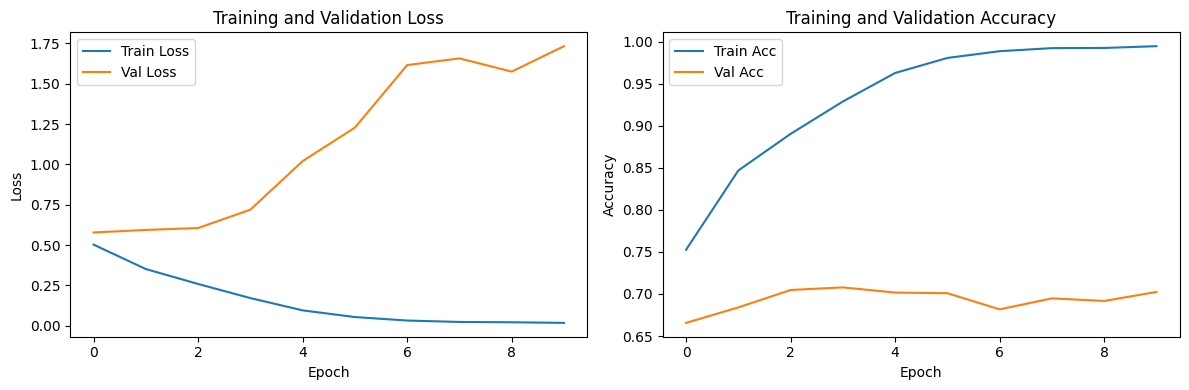

In [63]:
# plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# plot loss
ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Val Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()

# plot accuracy
ax2.plot(train_accs, label='Train Acc')
ax2.plot(val_accs, label='Val Acc')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

### Model 2: Encoder-Decoder
*In both variants, the premise and hypothesis sentences are first tokenized, embedded, and processed. Model 2A applies self-attention on the encoder side, using an additive attention layer to highlight salient words within the premise before combining it with the hypothesis representation. Model 2B instead adopts decoder-side (Bahdanau) cross-attention, where each decoding step for the hypothesis dynamically attends to the encoded premise states, creating explicit word-to-word alignment between the two sentences. Both models share the same preprocessing pipeline, embedding dimension, hidden size, and training loop as the baseline BiLSTM, ensuring a fair comparison. We evaluate both variants on the same NLI dataset and include attention-weight visualizations to qualitatively analyse how each model focuses on relevant premise tokens during inference.*

In [64]:
# Common training/eval utilities (reuse across models)
criterion = nn.CrossEntropyLoss()  # or with label_smoothing=0.05
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train(); tot=0; preds=[]; gold=[]
    for prem, hyp, y in dataloader:
        prem, hyp, y = prem.to(device), hyp.to(device), y.to(device)
        optimizer.zero_grad()
        logits, _ = model(prem, hyp)
        loss = criterion(logits, y)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        tot += loss.item()
        preds.extend(logits.argmax(1).detach().cpu().numpy())
        gold.extend(y.cpu().numpy())
    return tot/len(dataloader), accuracy_score(gold, preds)

@torch.no_grad()
def evaluate(model, dataloader, criterion, device):
    model.eval(); tot=0; preds=[]; gold=[]
    for prem, hyp, y in dataloader:
        prem, hyp, y = prem.to(device), hyp.to(device), y.to(device)
        logits, _ = model(prem, hyp)
        loss = criterion(logits, y)
        tot += loss.item()
        preds.extend(logits.argmax(1).cpu().numpy())
        gold.extend(y.cpu().numpy())
    return tot/len(dataloader), accuracy_score(gold, preds), preds, gold


####Model 2A — Encoder-side attention (self-attn over premise)

In [65]:

class SelfAttentionPool(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.W = nn.Linear(dim, dim)
        self.v = nn.Linear(dim, 1, bias=False)
    def forward(self, H, mask):
        scores = self.v(torch.tanh(self.W(H))).squeeze(-1)
        scores = scores.masked_fill(mask == 0, -1e9)
        all_pad = (mask.sum(1) == 0)
        if all_pad.any():
            scores[all_pad] = -1e9; scores[all_pad,0] = 0.0
        alpha = torch.softmax(scores, dim=-1)
        p_star = torch.bmm(alpha.unsqueeze(1), H).squeeze(1)
        return p_star, alpha

class EncoderSideAttentionNLI(nn.Module):
    def __init__(self, vocab_size, emb_dim, hid_dim, num_classes, pad_idx=0, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)
        self.enc_p = nn.LSTM(emb_dim, hid_dim, batch_first=True, bidirectional=True)
        self.enc_h = nn.LSTM(emb_dim, hid_dim, batch_first=True, bidirectional=True)
        self.pool_p = SelfAttentionPool(2*hid_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(8*hid_dim, 2*hid_dim)
        self.fc2 = nn.Linear(2*hid_dim, num_classes)
    def _mask(self, x): return (x != 0).long()
    def _encode(self, x, lstm):
        H, _ = lstm(self.embedding(x))
        return H
    def _max_pool(self, H, mask):
        masked = H.masked_fill(mask.unsqueeze(-1)==0, float('-inf'))
        pooled = masked.max(1).values
        is_all_pad = (mask.sum(1) == 0)
        if is_all_pad.any(): pooled[is_all_pad] = 0.0
        return pooled
    def forward(self, prem_ids, hyp_ids):
        prem_mask, hyp_mask = self._mask(prem_ids), self._mask(hyp_ids)
        H_p = self._encode(prem_ids, self.enc_p)
        p_star, alpha = self.pool_p(H_p, prem_mask)
        H_h = self._encode(hyp_ids, self.enc_h)
        h_star = self._max_pool(H_h, hyp_mask)
        z = torch.cat([p_star, h_star, torch.abs(p_star-h_star), p_star*h_star], dim=-1)
        out = self.dropout(torch.relu(self.fc1(z)))
        logits = self.fc2(out)
        return logits, alpha


In [66]:
model_2a = EncoderSideAttentionNLI(vocab_size, EMBEDDING_DIM, HIDDEN_DIM, NUM_CLASSES, pad_idx=0).to(device)
opt_2a = optim.Adam(model_2a.parameters(), lr=LEARNING_RATE)
best = 0.0
for e in range(NUM_EPOCHS):
    tr_l,tr_a = train_epoch(model_2a, train_loader, criterion, opt_2a, device)
    va_l,va_a,_,_ = evaluate(model_2a, val_loader, criterion, device)
    print(f"[2A] {e+1}: train {tr_l:.4f}/{tr_a:.4f} | val {va_l:.4f}/{va_a:.4f}")
    if va_a>best: best=va_a; torch.save(model_2a.state_dict(),"best_model_2a.pth")
# test
model_2a.load_state_dict(torch.load("best_model_2a.pth"))
tl, ta, tp, tt = evaluate(model_2a, test_loader, criterion, device)
print(f"[2A] Test: loss {tl:.4f} acc {ta:.4f}")
print(classification_report(tt, tp, target_names=['entails','neutral'], zero_division=0))


[2A] 1: train 0.4918/0.7614 | val 0.6281/0.6794
[2A] 2: train 0.3489/0.8506 | val 0.5911/0.6917
[2A] 3: train 0.2522/0.8957 | val 0.6248/0.7040
[2A] 4: train 0.1475/0.9439 | val 0.8744/0.6994
[2A] 5: train 0.0733/0.9739 | val 1.1064/0.6933
[2A] 6: train 0.0389/0.9869 | val 1.2855/0.6994
[2A] 7: train 0.0277/0.9912 | val 1.3430/0.6956
[2A] 8: train 0.0227/0.9927 | val 1.6391/0.6833
[2A] 9: train 0.0181/0.9944 | val 1.6750/0.7132
[2A] 10: train 0.0176/0.9951 | val 1.7142/0.6940
[2A] Test: loss 1.8506 acc 0.6990
              precision    recall  f1-score   support

     entails       0.65      0.53      0.58       842
     neutral       0.72      0.81      0.76      1284

    accuracy                           0.70      2126
   macro avg       0.69      0.67      0.67      2126
weighted avg       0.69      0.70      0.69      2126



####Model 2B — Decoder-side (Bahdanau cross-attn)

In [67]:
class BahdanauAttention(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.W_h = nn.Linear(dim, dim, bias=False)
        self.W_s = nn.Linear(dim, dim, bias=False)
        self.v   = nn.Linear(dim, 1,  bias=False)

    def forward(self, Hk, q, mask):
        scores = self.v(torch.tanh(self.W_h(Hk) + self.W_s(q).unsqueeze(1))).squeeze(-1)
        scores = scores.masked_fill(mask==0, -1e9)
        all_pad = (mask.sum(1)==0)
        if all_pad.any():
            scores[all_pad] = -1e9; scores[all_pad,0] = 0.0
        alpha = torch.softmax(scores, dim=-1)
        ctx = torch.bmm(alpha.unsqueeze(1), Hk).squeeze(1)
        return ctx, alpha

class DecoderSideAttentionNLI(nn.Module):
    def __init__(self, vocab_size, emb_dim, hid_dim, num_classes, pad_idx=0, dropout=0.4):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)
        self.enc_p = nn.LSTM(emb_dim, hid_dim, batch_first=True, bidirectional=True)
        self.dec_h = nn.LSTM(emb_dim + 2*hid_dim, hid_dim, batch_first=True)
        self.attn  = BahdanauAttention(2*hid_dim)
        self.proj_q = nn.Linear(hid_dim, 2*hid_dim, bias=False)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hid_dim + 2*hid_dim, 2*hid_dim)
        self.fc2 = nn.Linear(2*hid_dim, num_classes)

    def forward(self, prem_ids, hyp_ids):
        B, Th = hyp_ids.size(0), hyp_ids.size(1)
        prem_mask = (prem_ids != 0).long()
        H_p, _ = self.enc_p(self.embedding(prem_ids))
        emb_h = self.embedding(hyp_ids)
        h_t = torch.zeros(1,B,self.dec_h.hidden_size, device=emb_h.device)
        c_t = torch.zeros(1,B,self.dec_h.hidden_size, device=emb_h.device)
        ctx_prev = torch.zeros(B, H_p.size(-1), device=emb_h.device)
        outs, attn_all = [], []
        for t in range(Th):
            dec_in = torch.cat([emb_h[:,t,:], ctx_prev], dim=-1).unsqueeze(1)
            dec_out, (h_t,c_t) = self.dec_h(dec_in, (h_t,c_t))
            s_t = dec_out.squeeze(1)
            q_t = self.proj_q(s_t)
            ctx_t, alpha_t = self.attn(H_p, q_t, prem_mask)
            outs.append(torch.cat([s_t, ctx_t], dim=-1))
            attn_all.append(alpha_t.unsqueeze(1))
            ctx_prev = ctx_t
        dec_stack = torch.stack(outs, dim=1)
        hyp_mask = (hyp_ids != 0).long()
        mask3 = hyp_mask.unsqueeze(-1).float()
        g = (dec_stack*mask3).sum(1) / hyp_mask.sum(1).clamp(min=1).unsqueeze(-1).float()
        out = self.dropout(torch.relu(self.fc1(g)))
        logits = self.fc2(out)
        A = torch.cat(attn_all, dim=1) if attn_all else None
        return logits, A


In [ ]:
model_2b = DecoderSideAttentionNLI(vocab_size, EMBEDDING_DIM, HIDDEN_DIM, NUM_CLASSES, pad_idx=0).to(device)
opt_2b = optim.Adam(model_2b.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
best=0.0; patience, wait = 3, 0

for e in range(NUM_EPOCHS):
    tr_l,tr_a = train_epoch(model_2b, train_loader, criterion, opt_2b, device)
    va_l,va_a,_,_ = evaluate(model_2b, val_loader, criterion, device)
    print(f"[2B] {e+1}: train {tr_l:.4f}/{tr_a:.4f} | val {va_l:.4f}/{va_a:.4f}")
    if va_a>best: best, wait = va_a, 0; torch.save(model_2b.state_dict(),"best_model_2b.pth")

model_2b.load_state_dict(torch.load("best_model_2b.pth"))
tl, ta, tp, tt = evaluate(model_2b, test_loader, criterion, device)
print(f"[2B] Test: loss {tl:.4f} acc {ta:.4f}")
print(classification_report(tt, tp, target_names=['entails','neutral'], zero_division=0))



[2B] 1: train 0.5148/0.7428 | val 0.5613/0.6979
[2B] 2: train 0.3656/0.8407 | val 0.5258/0.7224
[2B] 3: train 0.2826/0.8804 | val 0.6629/0.6994
[2B] 4: train 0.2051/0.9163 | val 0.8712/0.6879
[2B] 5: train 0.1387/0.9439 | val 0.9687/0.7109


### Model 3: Transformer

In [69]:
PADDING_IDX = 0
CLS_IDX = vocab_size          # new id after existing vocab
SEP_IDX = vocab_size + 1      # new id after existing vocab
VOCAB_SIZE = vocab_size + 2   # total size including CLS/SEP

# ----- Build concatenated sequences: [CLS] premise [SEP] hypothesis [SEP] -----
MAX_SEQ_LEN = 256

def concatenate_and_pad(p_idx_list, h_idx_list, max_len, padding_idx, cls_idx, sep_idx):
    combined_sequences = []
    for p_idx, h_idx in zip(p_idx_list, h_idx_list):
        combined = [cls_idx] + p_idx + [sep_idx] + h_idx + [sep_idx]
        if len(combined) > max_len:
            combined = combined[:max_len]
        elif len(combined) < max_len:
            combined = combined + [padding_idx] * (max_len - len(combined))
        combined_sequences.append(combined)
    return combined_sequences

print(f"Concatenation & padding sequences to {MAX_SEQ_LEN}...")
train_sequence_idx = concatenate_and_pad(train_premise_idx, train_hypothesis_idx, MAX_SEQ_LEN, PADDING_IDX, CLS_IDX, SEP_IDX)
val_sequence_idx   = concatenate_and_pad(val_premise_idx,   val_hypothesis_idx,   MAX_SEQ_LEN, PADDING_IDX, CLS_IDX, SEP_IDX)
test_sequence_idx  = concatenate_and_pad(test_premise_idx,  test_hypothesis_idx,  MAX_SEQ_LEN, PADDING_IDX, CLS_IDX, SEP_IDX)
print("Concatenation & padding complete.")


Concatenation & padding sequences to 256...
Concatenation & padding complete.


In [70]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))  # [1, max_len, d_model]
    def forward(self, x: torch.Tensor) -> torch.Tensor:     # x: [B,T,E]
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

def create_padding_mask(input_indices, padding_idx):
    return (input_indices == padding_idx)

# ----- Dataset -----
class NliDataset(Dataset):
    def __init__(self, sequence_idx, labels):
        self.sequence_idx = torch.tensor(np.array(sequence_idx), dtype=torch.long)
        self.labels = torch.tensor(np.array(labels), dtype=torch.long)
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return self.sequence_idx[idx], self.labels[idx]

In [71]:
class Transformer(nn.Module):
    def __init__(self, vocab_size, embedding_dim, max_seq_len, num_layers, num_heads,
                 dim_feedforward, dropout, num_classes, padding_idx):
        super().__init__()
        self.padding_idx = padding_idx
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
        self.pos_encoder = PositionalEncoding(embedding_dim, dropout, max_len=max_seq_len)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim,
            nhead=num_heads,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,          # use [B,T,E]
            activation='gelu'
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)

        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(embedding_dim, dim_feedforward),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, num_classes)
        )
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        # Only init the classifier explicitly; embeddings/encoder use defaults
        for name, param in self.named_parameters():
            if 'classifier' in name and 'weight' in name:
                nn.init.uniform_(param, -initrange, initrange)
            elif 'classifier' in name and 'bias' in name:
                nn.init.zeros_(param)

    def forward(self, combined_ix):                         # combined_ix: [B,T]
        key_padding_mask = create_padding_mask(combined_ix, self.padding_idx)  # [B,T] True at PAD
        x = self.embedding(combined_ix)                    # [B,T,E]
        x = self.pos_encoder(x)                            # [B,T,E]
        enc = self.transformer_encoder(x, src_key_padding_mask=key_padding_mask)  # [B,T,E]
        cls_vec = enc[:, 0, :]                             # take [CLS] position
        logits = self.classifier(cls_vec)                  # [B,2]
        return logits

In [33]:
EMBEDDING_DIM    = 256
NUM_LAYERS       = 3
NUM_HEADS        = 4
DIM_FEEDFORWARD  = 4 * EMBEDDING_DIM
DROPOUT          = 0.1
NUM_CLASSES      = 2
LEARNING_RATE    = 1e-4
BATCH_SIZE       = 32
NUM_EPOCHS       = 10
MODEL_SAVE_PATH  = "best_transformer.pth"

# ----- Model, criterion, optim -----
transformer_model = Transformer(
    vocab_size=VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    max_seq_len=MAX_SEQ_LEN,
    num_layers=NUM_LAYERS,
    num_heads=NUM_HEADS,
    dim_feedforward=DIM_FEEDFORWARD,
    dropout=DROPOUT,
    num_classes=NUM_CLASSES,
    padding_idx=PADDING_IDX
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(transformer_model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

# ----- DataLoaders -----
train_dataset = NliDataset(train_sequence_idx, train_labels)
val_dataset   = NliDataset(val_sequence_idx,   val_labels)
test_dataset  = NliDataset(test_sequence_idx,  test_labels)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)

# ----- Train / Eval loops -----
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    for seqs, labels in dataloader:
        seqs, labels = seqs.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(seqs)
        loss = criterion(logits, labels)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()
    return total_loss / max(1, len(dataloader))

@torch.no_grad()
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    all_preds, all_labels = [], []
    for seqs, labels in dataloader:
        seqs, labels = seqs.to(device), labels.to(device)
        logits = model(seqs)
        loss = criterion(logits, labels)
        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    acc = accuracy_score(all_labels, all_preds)
    return total_loss / max(1, len(dataloader)), acc, all_preds, all_labels

# ----- Training -----
best_val_acc = 0.0
print("\nStarting Training:")
for epoch in range(1, NUM_EPOCHS + 1):
    train_loss = train_one_epoch(transformer_model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, _, _ = evaluate_model(transformer_model, val_loader, criterion, device)
    print(f"[M3] Epoch {epoch}/{NUM_EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(transformer_model.state_dict(), MODEL_SAVE_PATH)
        print(f"  ↳ Saved best model with Val Acc: {best_val_acc:.4f}")

# ----- Final Test Eval -----
print("\nReport:")
state = torch.load(MODEL_SAVE_PATH)
transformer_model.load_state_dict(state)
transformer_model.to(device)

test_loss, test_acc, test_preds, test_true = evaluate_model(transformer_model, test_loader, criterion, device)
print(f"[M3] Test Loss: {test_loss:.4f}")
print(f"[M3] Test Accuracy: {test_acc:.4f}")
print(classification_report(test_true, test_preds, target_names=['entails', 'neutral'], zero_division=0))


Starting Training:


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:515: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


[M3] Epoch 1/10 | Train Loss: 0.6533 | Val Loss: 0.6172 | Val Acc: 0.6549
  ↳ Saved best model with Val Acc: 0.6549
[M3] Epoch 2/10 | Train Loss: 0.5475 | Val Loss: 0.7033 | Val Acc: 0.6549
[M3] Epoch 3/10 | Train Loss: 0.4857 | Val Loss: 0.6522 | Val Acc: 0.6564
  ↳ Saved best model with Val Acc: 0.6564
[M3] Epoch 4/10 | Train Loss: 0.4388 | Val Loss: 0.6546 | Val Acc: 0.6710
  ↳ Saved best model with Val Acc: 0.6710
[M3] Epoch 5/10 | Train Loss: 0.4078 | Val Loss: 0.8247 | Val Acc: 0.6304
[M3] Epoch 6/10 | Train Loss: 0.3814 | Val Loss: 0.6207 | Val Acc: 0.6702
[M3] Epoch 7/10 | Train Loss: 0.3600 | Val Loss: 0.6767 | Val Acc: 0.6741
  ↳ Saved best model with Val Acc: 0.6741
[M3] Epoch 8/10 | Train Loss: 0.3368 | Val Loss: 0.6947 | Val Acc: 0.6710
[M3] Epoch 9/10 | Train Loss: 0.3188 | Val Loss: 0.6675 | Val Acc: 0.6610
[M3] Epoch 10/10 | Train Loss: 0.2953 | Val Loss: 0.9860 | Val Acc: 0.6518

Report:
[M3] Test Loss: 0.6714
[M3] Test Accuracy: 0.6938
              precision    recal

# 3.Testing and Evaluation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

In [39]:
# ============================
# Unified Testing & Evaluation
# ============================
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd

def safe_load_state(path):
    """Load state_dict with weights_only=True when available (newer PyTorch),
    fallback to default for older versions."""
    try:
        return torch.load(path, weights_only=True)
    except TypeError:
        return torch.load(path)

def evaluate_and_report(model, weight_path, model_name):
    if model is None:
        print(f"[{model_name}] SKIPPED (model not defined).")
        return None
    if not os.path.exists(weight_path):
        print(f"[{model_name}] SKIPPED (weights not found at: {weight_path}).")
        return None

    print(f"\n[{model_name}] Loading weights from: {weight_path}")
    state = safe_load_state(weight_path)
    model.load_state_dict(state)
    tl, ta, preds, gold = evaluate(model, test_loader, criterion, device)
    print(f"[{model_name}] Test: loss {tl:.4f} acc {ta:.4f}")
    print(classification_report(gold, preds, target_names=['entails','neutral'], zero_division=0))

    # Confusion matrix (uncomment if you want the plots)
    # cm = confusion_matrix(gold, preds)
    # ConfusionMatrixDisplay(cm, display_labels=['entails','neutral']).plot(cmap='Blues')
    # plt.title(f'{model_name} — Test Confusion Matrix'); plt.show()

    return {"Model": model_name, "Test Loss": tl, "Test Acc": ta, "Preds": preds, "Gold": gold}

results = []

# -----------------
# Model 1: Siamese BiLSTM (commented until your teammate plugs it in)
# -----------------
# model_1 = SiameseBiLSTM(vocab_size, EMBEDDING_DIM, HIDDEN_DIM, NUM_CLASSES).to(device)
# results.append(evaluate_and_report(model_1, "best_siamese_bilstm.pth", "Model 1 — BiLSTM"))

# -----------------
# Model 2A: Encoder-side Attention (yours)
# -----------------
try:
    results.append(evaluate_and_report(model_2a, "best_model_2a.pth", "Model 2A — Enc Self-Attn"))
except NameError:
    print("[Model 2A] SKIPPED (model_2a not in scope).")

# -----------------
# Model 2B: Decoder-side Cross-Attention (yours)
# -----------------
try:
    results.append(evaluate_and_report(model_2b, "best_model_2b.pth", "Model 2B — Dec Cross-Attn"))
except NameError:
    print("[Model 2B] SKIPPED (model_2b not in scope).")

# -----------------
# Model 3: Transformer (commented until your teammate plugs it in)
# -----------------
# model_3 = YourTransformerClass(...).to(device)
# results.append(evaluate_and_report(model_3, "best_transformer.pth", "Model 3 — Transformer"))

# ---- Summary table ----
results = [r for r in results if r is not None]
if results:
    summary_rows = [{"Model": r["Model"], "Test Loss": round(r["Test Loss"], 4), "Test Acc": round(r["Test Acc"], 4)} for r in results]
    df_summary = pd.DataFrame(summary_rows).sort_values(by="Test Acc", ascending=False)
    print("\n=== Test Summary ===")
    display(df_summary)
else:
    print("\nNo models evaluated — define models or provide weight files first.")

# (Optional) save summary + raw preds to disk
try:
    if results:
        df_summary.to_csv("test_summary.csv", index=False)
        # Save per-model detailed preds
        for r in results:
            pd.DataFrame({"gold": r["Gold"], "pred": r["Preds"]}).to_csv(
                f"{r['Model'].replace(' ','_')}_test_preds.csv", index=False
            )
        print("Saved: test_summary.csv and *_test_preds.csv")
except Exception as e:
    print("Save error:", e)


[Model 2A] SKIPPED (model_2a not in scope).
[Model 2B] SKIPPED (model_2b not in scope).

No models evaluated — define models or provide weight files first.


## Object Oriented Programming codes here

*You can use multiple code snippets. Just add more if needed*